In [1]:
%env CUDA_VISIBLE_DEVICES=1,7
%env TMPDIR=/raid/users/ryan_cheng/tmp
import os
import glob
import re
import json
import random
import time
import pickle
from absl import app, flags
from tqdm import tqdm
from datetime import datetime
import openai
from openai import OpenAI
from transformers import AutoTokenizer
import pandas as pd
import numpy as np

np.random.seed(0)

try:
    from vllm import LLM, SamplingParams
    import ray
except ImportError:
    pass
with open(os.path.abspath('../ryan_openai.txt'), 'r') as f:
    # ../.. for notebook, .. for script
    client = OpenAI(api_key=f.read().rstrip('\n'))

vllm_alias = {
    'mistral': 'mistralai/Mistral-7B-v0.3',
    'mixtral': 'mistralai/Mixtral-8x7B-v0.1',
    'mistral-instruct': 'mistralai/Mistral-7B-Instruct-v0.3',
    'mixtral-instruct': 'mistralai/Mixtral-8x7B-Instruct-v0.1',

    'gemma': 'google/gemma-7b',
    'gemma-2-27b': 'google/gemma-2-27b',
    'gemma-2-27b-it': 'google/gemma-2-27b-it', # instruction tuned

    'Llama-3-70B': 'meta-llama/Meta-Llama-3-70B',
    'Llama-3-8B': 'meta-llama/Meta-Llama-3-8B',
    'Llama-3.1-405B': 'meta-llama/Meta-Llama-3.1-405B',
    'Llama-3.1-8B': 'meta-llama/Meta-Llama-3.1-8B',
    'Llama-3.1-70B': 'meta-llama/Meta-Llama-3.1-70B', 
    'Llama-3.1-405B-Instruct': 'meta-llama/Meta-Llama-3.1-405B-Instruct',
    'Llama-3.1-70B-Instruct': 'meta-llama/Meta-Llama-3.1-70B-Instruct',
    'Llama-3.1-8B-Instruct': 'meta-llama/Meta-Llama-3.1-8B-Instruct'
}

llm = None

# run 'ray start --head --num-gpus <NUM>' in bash first!
def setup_vllm(config, model):
    if config['gpus'] > 1:
        ray.init(ignore_reinit_error=True) 

    global llm
    global tokenizer

    if model in vllm_alias:
        tokenizer = AutoTokenizer.from_pretrained(vllm_alias[model])
    else:
        print('Attempting to use tokenizer for', model)
        try:
            tokenizer = AutoTokenizer.from_pretrained(model)
        except:
            print('Info: passing tokenizer setup')

    if model in vllm_alias:
    #     if config['fp8']:
    #         llm = LLM(model=vllm_alias[model], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'], gpu_memory_utilization=0.75)
        if vllm_alias[model] == 'meta-llama/Meta-Llama-3.1-70B' or vllm_alias[model] == 'meta-llama/Meta-Llama-3.1-70B-Instruct':
            llm = LLM(model=vllm_alias[model], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'], gpu_memory_utilization=0.9, max_model_len=12880)
        else:
            llm = LLM(model=vllm_alias[model], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'])
    else:
        try:
            llm = LLM(model=model, tensor_parallel_size=config['gpus'], download_dir=config['model_dir'])
        except:
            print('Info: Passing vllm setup')
            try:
                llm = AutoModelForCausalLM.from_pretrained(
                    model,
                    torch_dtype=torch.bfloat16,
                    low_cpu_mem_usage=True,
                    device_map="auto"
                )
            except:
                print("Info: passing finetuned model setup")
        

def completion_create_helper(model_name, config, prompt):
    # limit prompt in all cases
    if model_name not in vllm_alias:
        # for some reason vLLM models simply repeat this last statement if present
        prompt += " Limit your answer to three sentences or less!"

    if model_name in vllm_alias and not llm:
        # set up vllm if not already set up
        setup_vllm(config, model_name)
        
    ret = '' # return the output ret at the end and use to calculate cost

    if model_name == "gpt-3.5-turbo-instruct":
        ret = client.completions.create(
                model="gpt-3.5-turbo-instruct",
                prompt=prompt,
                temperature=0.8,
                max_tokens=config['max_tokens'],
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
        )
        ret = ret.choices[0].text.strip()
        #find_line = ret.find("\n")
        #if find_line != -1:
            #ret = ret[:find_line]
    elif model_name in ["gpt-3.5-turbo", "gpt-3.5-turbo-16k", "gpt-4-turbo", "gpt-4o", "gpt-4o-mini"]:
        ret = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "system", "content": prompt}],
            max_tokens=config['max_tokens']
        )
        ret = ret.choices[-1].message.content

    elif model_name in vllm_alias and llm:
        sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=config['max_tokens'])
        messages = [
            {"role": "user", "content": prompt}
        ]
        if tokenizer.chat_template:
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        output = llm.generate([prompt], sampling_params)
        ret = output[0].outputs[0].text

    else: # specify model path of finetuned model in model directory
        inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
        with torch.no_grad():
            output_ids = llm.generate(**inputs, max_length=8192)
        output_ids = output_ids[:, inputs.input_ids.shape[1]:]
        ret = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # if config['model'] not in vllm_alias:
    #     running_cost_for_iteration += api_cost(prompt=prompt, answer=ret, model=config['model'])
    #     if config['verbose']:
    #         print(f"RUNNING COST FOR ITERATION SO FAR: {running_cost_for_iteration}")
    
    return ret

def completion_create(model_name, config, prompt, keep_trying=False):
    try:
        return completion_create_helper(model_name, config, prompt)
    except (openai.APIError, openai.OpenAIError) as e:
        # print("ERROR", e)
        # print("sleeping for 10 seconds.")
        time.sleep(10)
        if keep_trying:
            return completion_create(model_name, config, prompt, keep_trying)
        else:
            return None
            
def write_json(write_path, json_dict):
    if not os.path.exists(write_path):
        with open(write_path, 'w') as f:
            json.dump([], f)
    with open(write_path, 'r') as f:
        evaluations = json.load(f)
    evaluations.append(json_dict)
    with open(write_path, 'w') as f:
        json.dump(evaluations, f, indent=4)

env: CUDA_VISIBLE_DEVICES=1,7
env: TMPDIR=/raid/users/ryan_cheng/tmp
INFO 04-08 09:42:30 __init__.py:190] Automatically detected platform cuda.


In [24]:
import matplotlib.pyplot as plt

data_dir = "/nfs/kun2/users/ryan_cheng/consistency_LLMs/data/anthology/exp/"
file_pattern = "*.json"

files = glob.glob(os.path.join(data_dir, file_pattern))

metrics = {}

for file in files:
    filename = os.path.basename(file)
    metrics[filename] = {}
    print(f"Processing file: {filename}")
    with open(file, 'r') as f:
        data = json.load(f)
        for conversation in data:
            for key, value in conversation.items():
                if key not in metrics[filename]:
                    metrics[filename][key] = []
                if key == "P1_survey_consistency_score" or key == "P2_survey_consistency_score":
                    value = value / 5
                metrics[filename][key].append(value)


Processing file: gpt-4o-mini_0.json
Processing file: Llama-3.1-8B-Instruct_0.json
Processing file: Llama-3.1-70B_0.json
Processing file: Llama-3.1-8B_0.json
Processing file: Llama-3.1-70B-Instruct_0.json


In [25]:
metrics['gpt-4o-mini_0.json']

{'task_name': ['Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology',
  'Anthology'],
 'P1': ['My name is Joon, I’m 22 years old, and I was born in South Korea but immigrated to the US at the age of four. Growing up in a Korean household, I learned the values of hard work and family from my grandparents, who faced significant hardships in their lives, leading to my current belief that no one deserves to be poor and that conversation is vital for progress. Now a college graduate from the University of Washington studying law and business, I’m passionate about social justice and engage with diverse opinions to challenge hypocrisy within society, all while navigating my identities as a bisexual, non-binary individual in a rapidly changing world.',
  "My name is Alex, I'm 30 years old, and I grew up in North East Ohio, in a family that emphasized education and hard work. My parents are both from Polish descent an

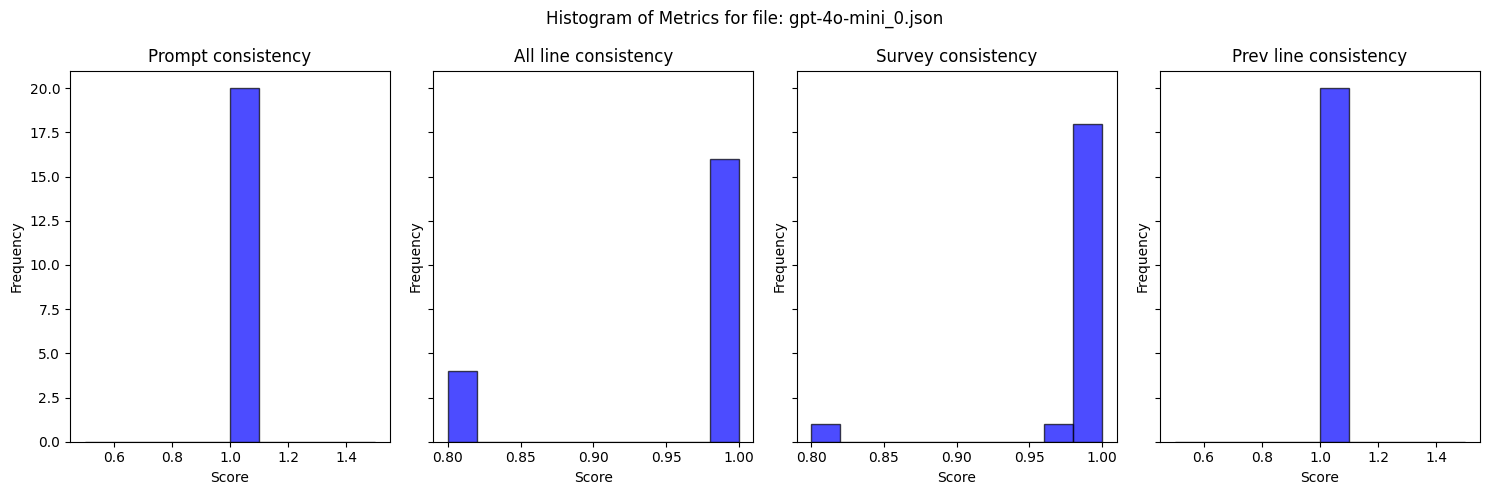

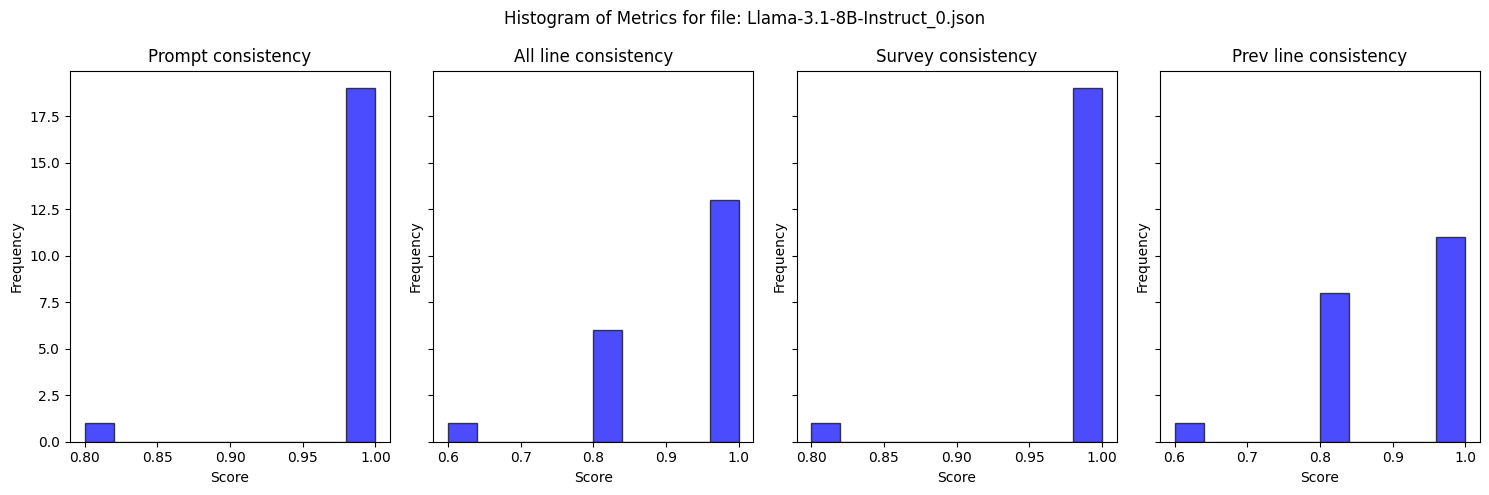

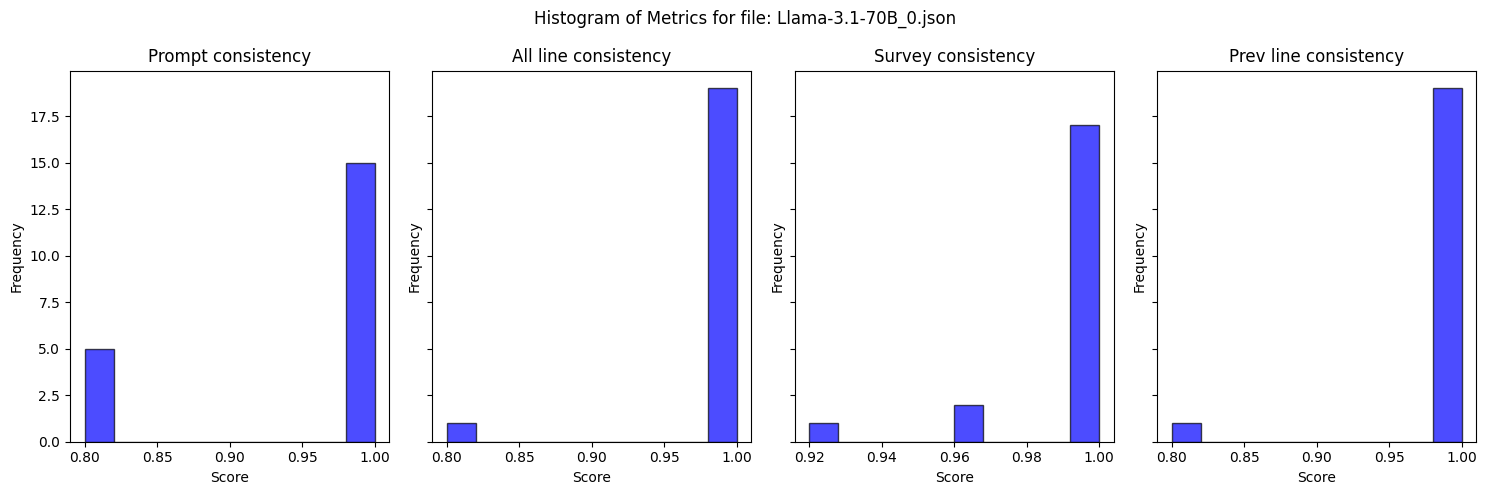

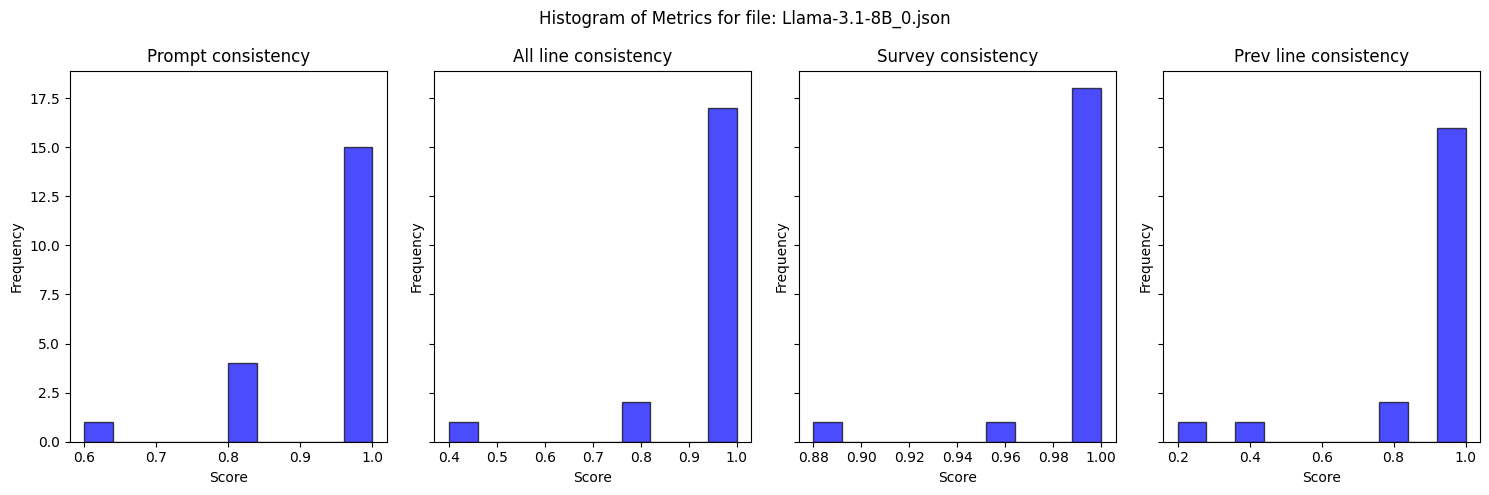

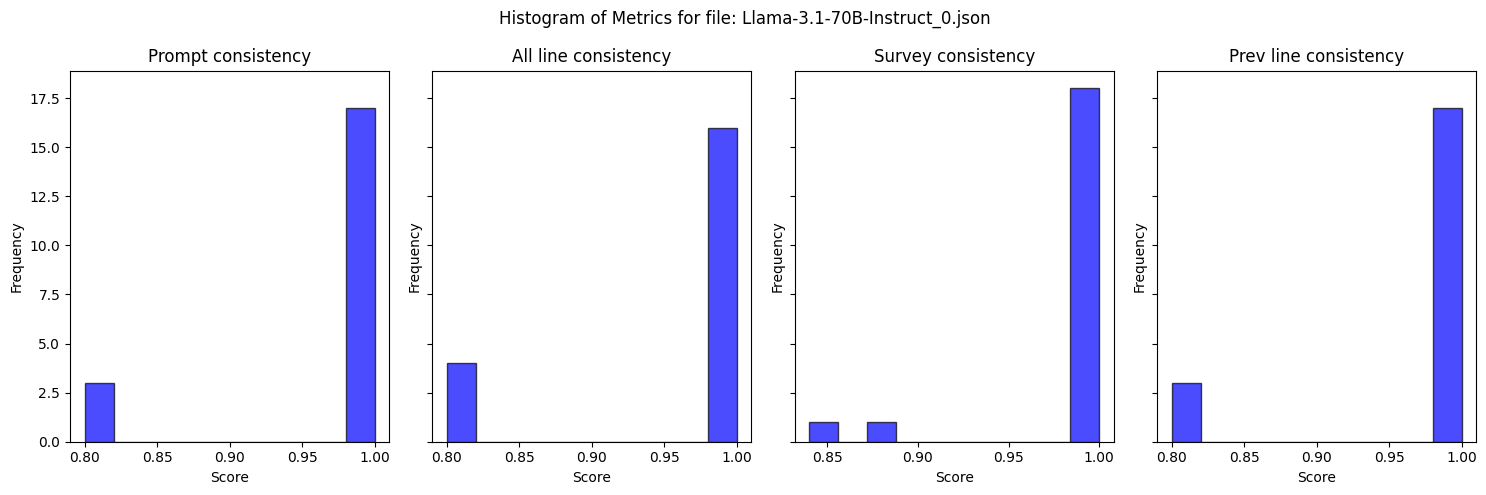

In [26]:
# Extract metrics from conversations


# for conversation in conversations:
#     metrics["prompt_consistency"].extend([
#         conversation.get("P1_prompt_consistency_score", 0),
#         conversation.get("P2_prompt_consistency_score", 0)
#     ])
#     metrics["all_line_consistency"].extend([
#         conversation.get("P1_all_line_consistency_score", 0),
#         conversation.get("P2_all_line_consistency_score", 0)
#     ])
#     metrics["prev_line_consistency"].extend([
#         conversation.get("P1_prev_line_consistency_score", 0),
#         conversation.get("P2_prev_line_consistency_score", 0)
#     ])


summarized_metrics = {}

for file in files:
    plot_metrics = {
        "prompt_consistency": [],
        "all_line_consistency": [],
        "survey_consistency": [],
        "prev_line_consistency": []
    }
    
    filename = os.path.basename(file)

    summarized_metrics[filename] = {}
    conversations = metrics[filename]
    plot_metrics["prompt_consistency"].extend(conversations.get("P1_prompt_consistency_score", []))
    plot_metrics["prompt_consistency"].extend(conversations.get("P2_prompt_consistency_score", []))
    plot_metrics["all_line_consistency"].extend(conversations.get("P1_all_line_consistency_score", []))
    plot_metrics["all_line_consistency"].extend(conversations.get("P2_all_line_consistency_score", []))
    plot_metrics["survey_consistency"].extend(conversations.get("P1_survey_consistency_score", []))
    plot_metrics["survey_consistency"].extend(conversations.get("P2_survey_consistency_score", []))
    plot_metrics["prev_line_consistency"].extend(conversations.get("P1_prev_line_consistency_score", []))
    plot_metrics["prev_line_consistency"].extend(conversations.get("P2_prev_line_consistency_score", []))

    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle("Histogram of Metrics for file: " + filename)
    #print("Metrics for file: ", filename)
    for ax, (metric, values) in zip(axes, plot_metrics.items()):
        #print(f"Metric: {metric}")
        #print('Mean: ', np.mean(values))
        #print('Std: ', np.std(values))
        summarized_metrics[filename][metric] = {
            "mean": np.mean(values),
            "std": np.std(values)
        }
        ax.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(metric.replace("_", " ").capitalize())
        ax.set_xlabel("Score")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

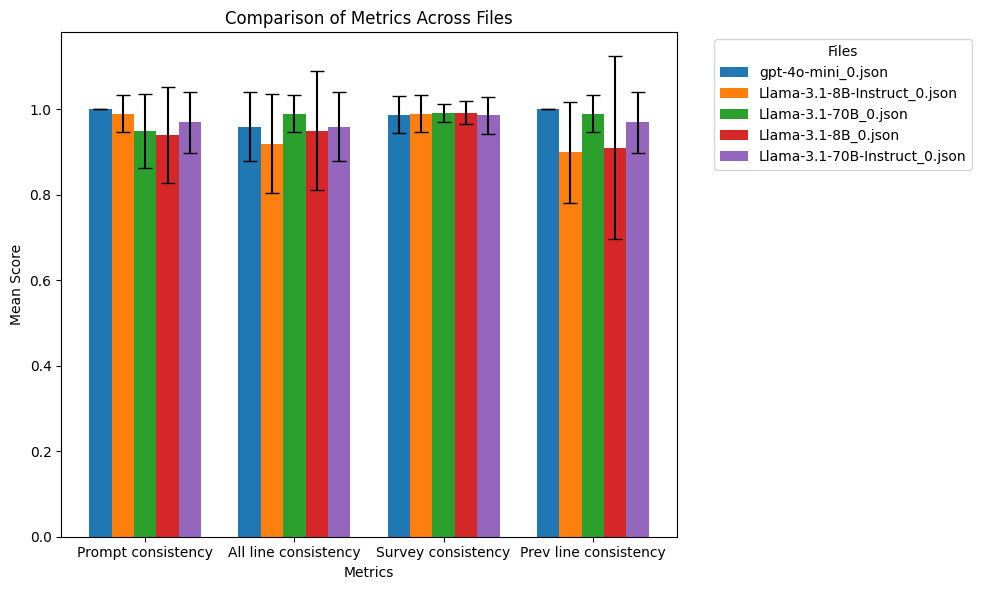

<Figure size 640x480 with 0 Axes>

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_to_plot)) 
width = 0.15  # 

for i, filename in enumerate(filenames):
    means = [summarized_metrics[filename][metric]["mean"] for metric in metrics_to_plot]
    stds = [summarized_metrics[filename][metric]["std"] for metric in metrics_to_plot]
    ax.bar(x + i * width, means, width, yerr=stds, label=filename, capsize=5)

# Add labels, title, and legend
ax.set_xticks(x + width * (len(filenames) - 1) / 2)
ax.set_xticklabels([metric.replace("_", " ").capitalize() for metric in metrics_to_plot])
ax.set_xlabel("Metrics")
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Metrics Across Files")
ax.legend(title="Files", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

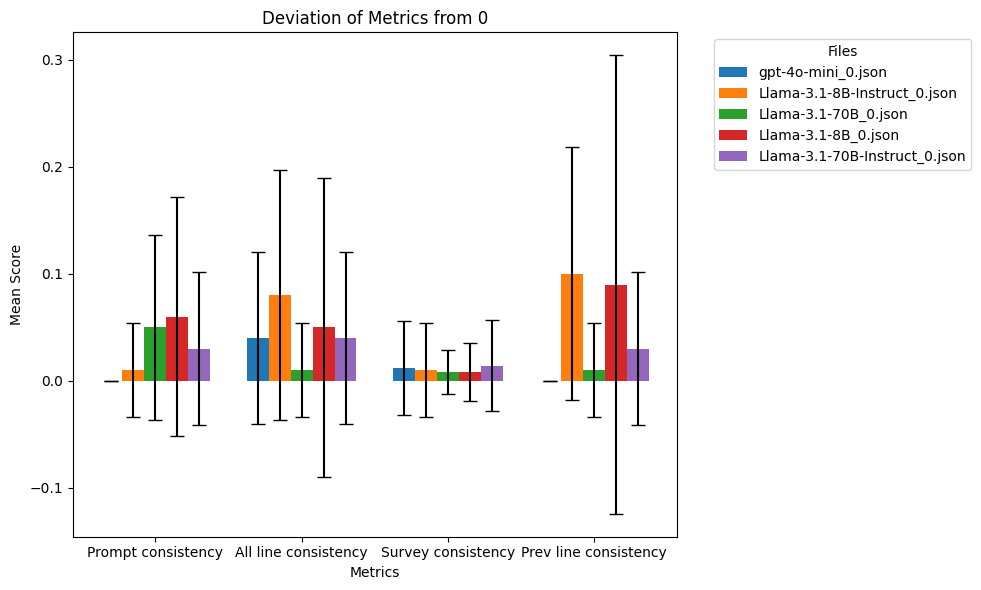

<Figure size 640x480 with 0 Axes>

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_to_plot)) 
width = 0.15  # 

for i, filename in enumerate(filenames):
    means = [1-summarized_metrics[filename][metric]["mean"] for metric in metrics_to_plot]
    stds = [summarized_metrics[filename][metric]["std"] for metric in metrics_to_plot]
    ax.bar(x + i * width, means, width, yerr=stds, label=filename, capsize=5)

# Add labels, title, and legend
ax.set_xticks(x + width * (len(filenames) - 1) / 2)
ax.set_xticklabels([metric.replace("_", " ").capitalize() for metric in metrics_to_plot])
ax.set_xlabel("Metrics")
ax.set_ylabel("Mean Score")
ax.set_title("Deviation of Metrics from 0")
ax.legend(title="Files", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

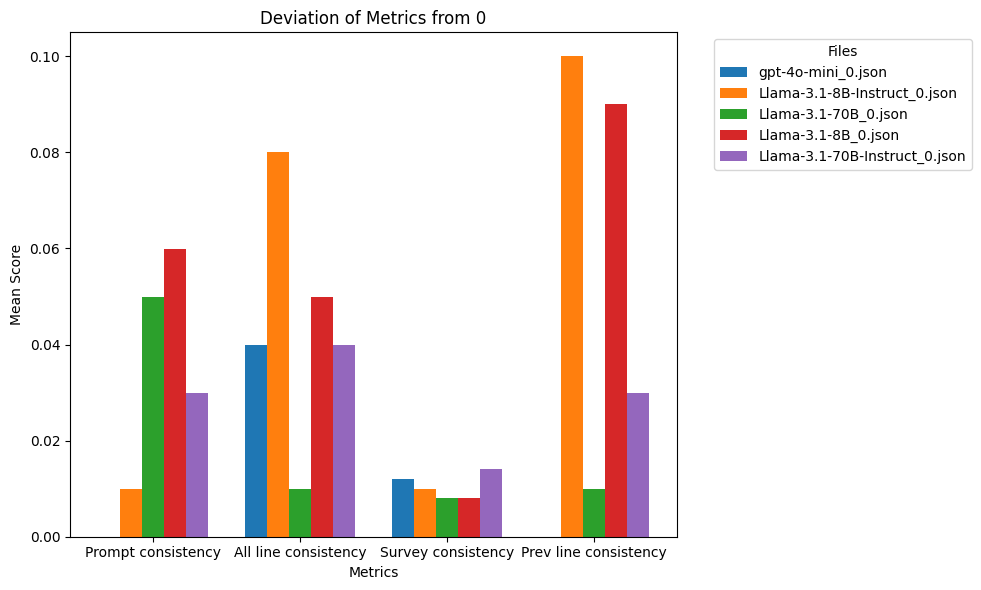

<Figure size 640x480 with 0 Axes>

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_to_plot)) 
width = 0.15  # 

for i, filename in enumerate(filenames):
    means = [1-summarized_metrics[filename][metric]["mean"] for metric in metrics_to_plot]
    #stds = [summarized_metrics[filename][metric]["std"] for metric in metrics_to_plot]
    ax.bar(x + i * width, means, width, label=filename, capsize=5)

# Add labels, title, and legend
ax.set_xticks(x + width * (len(filenames) - 1) / 2)
ax.set_xticklabels([metric.replace("_", " ").capitalize() for metric in metrics_to_plot])
ax.set_xlabel("Metrics")
ax.set_ylabel("Mean Score")
ax.set_title("Deviation of Metrics from 0")
ax.legend(title="Files", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()